In [1]:
# Homework 6 (due 08/08/2024)

# Neural networks and computer vision

### Objective
In this week's project, you will learn to train, validate, and test a neural network. You will explore how inputs change through feature extraction in convolutional neural networks (CNNs), and you will interpret the trained filters by the network.

#### Dataset

You will use the MNIST dataset, a standard dataset of handwritten digits, which is widely used for training and testing image processing systems.

#### Instructions

The code example below demonstrates how to define, train, validate, and test a CNN. The training and test accuracy after each completed epoch are shown after a completed

**1. Explore a working example**
1. Open `example.ipynb` and read the code.
2. Consult the pytorch documentation to learn what the arguments of the various employed pytorch functions mean.
3. Run the code.
4. Replace SGD with Adam in the training process. Then run the code again.
5. Save the output figures that show training and validation accuracy as a function of the number of epochs in your file system.

**2. Build a network**
Create your own working example. (You are allowed to copy any amount of code from `example.ipynb`.) Your CNN should be different from the CNN in the working example in the following ways:
1. The new CNN should have three convolutional layers instead of two. The first layer creates 32 channels. The second layer creates 64 channels, and the third layer creates 128 channels.
2. The pooling layer after the third layer should not employ any padding.
3. The last hidden layer should have 512 neurons.
4. For all layers except the output layer, the activation function should be a ReLU (use `torch.nn.ReLU`).

**3. Train and evaluate a neural network**
1. Train the neural network that you have constructed in the previous step. How have the upgrades with respect to the CNN in `example.ipynb` affected the CNN's training time?
2. Test the neural network. How have the upgrades with respect to the CNN in `example.ipynb` affected the CNN's validation accuracy?
3. Identify the number $k$ of training epochs that gives you a good tradeoff between training time and validation accuracy.
4. Run your code again using $k$ epochs during training. Time the training (e.g. using the python library `time`).

**4. Model validation and model selection**
1. Use the validation set approach to identify the best number $c$ of channels in the first convolutional layer (consider $c\in\{2,15\}$).
2. Update your neural network architecture so that the first convolutional layer has $c$ channels.

**5. Visualizing feature extraction**
1. Use the function `plot_mapped_features` to view an input image and the corresponding first channel of the hidden state for each feature-extraction layer (i.e., each convolution layer and each pooling layer).
2. Update the function so that it shows all channels instead of just one.
3. Comment on where you observe differences between the channels within a layer.

**6. Visualizing and interpreting filters**
1. Use the function `plot_filters` to view the trained filters of the first convolutional layer.
2. Identify the filters that perform blurring, sharpening, or horizontal or vertical edge detection.

**7. Comparison to logistic regression**
1. Construct and run a pipeline for multiclass logistic regression of the MNIST dataset using sklearn.
2. Comment on how the training time and test accuracy of logistic regression compare to the CNN.
3. Now run multiclass logistic regression on the MNIST data set using one of the hidden states of the CNN (i.e., $\vec{x}^{(2)}$, $\vec{x}^{(3)}$, ..., $\vec{x}^{(7)}$) as inputs. Which set of inputs yields the best classification results?

In [10]:
# import packages
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: __MACOSX/._data         
   creating: data/MNIST/
  inflating: __MACOSX/data/._MNIST   
   creating: data/MNIST/raw/
  inflating: __MACOSX/data/MNIST/._raw  
  inflating: data/MNIST/raw/t10k-images-idx3-ubyte  
  inflating: __MACOSX/data/MNIST/raw/._t10k-images-idx3-ubyte  
  inflating: data/MNIST/raw/t10k-labels-idx1-ubyte  
  inflating: __MACOSX/data/MNIST/raw/._t10k-labels-idx1-ubyte  
  inflating: data/MNIST/raw/train-images-idx3-ubyte  
  inflating: __MACOSX/data/MNIST/raw/._train-images-idx3-ubyte  
  inflating: data/MNIST/raw/t10k-images-idx3-ubyte.gz  
  inflating: __MACOSX/data/MNIST/raw/._t10k-images-idx3-ubyte.gz  
  inflating: data/MNIST/raw/train-images-idx3-ubyte.gz  
  inflating: __MACOSX/data/MNIST/raw/._train-images-idx3-ubyte.gz  
  inflating: data/MNIST/raw/train-labels-idx1-ubyte.gz  
  inflating: __MACOSX/data/MNIST/raw/._train-labels-idx1-ubyte.gz  
  inflating: data/MNIST/raw/train-labels-idx1-ubyte  
  inflating

In [17]:
# Function to visualize the feature maps produced by different layers for a given image
def plot_mapped_features(model, image, layers, show_all_channels=False):
    '''Example usage:

    >>> examples = iter(test_loader)
    >>> example_data, example_labels = next(examples) # get one batch from test set
    >>> example_image = example_data[0]
    >>> layers = [model.conv1, model.pool, model.conv2, model.pool]
    >>> plot_mapped_features(model, example_image, layers)

    '''
    # Add a batch dimension to the image tensor (from (channels, height, width) to (1, channels, height, width))
    x = image.unsqueeze(0).to(device)

    if show_all_channels:
        for i, layer in enumerate(layers):
            x = layer(x)

            num_channels = x.shape[1]

            # Create subplots for all channels
            fig, axes = plt.subplots(1, num_channels, figsize=(30, 20))

            for j in range(num_channels):
                feature_map = x[0, j].detach().cpu().numpy()
                axes[j].imshow(feature_map, cmap='gray')
                axes[j].axis('off')
                axes[j].set_title(f'Layer {i+1}: Channel {j+1}')

            plt.show()
    else:
        # Create a horizontal row of subplots for the first channel of each layer
        fig, axes = plt.subplots(1, len(layers), figsize=(20, 5))

        for i, layer in enumerate(layers):
            x = layer(x)
            feature_map = x[0, 0].detach().cpu().numpy()

            axes[i].imshow(feature_map, cmap='gray')
            axes[i].axis('off')
            layer_name = layer.__class__.__name__
            axes[i].set_title(f'Layer {i+1}: {layer_name} (First Channel)')

        plt.show()

# Function to visualize the filters of a given convolutional layer
def plot_filters(layer, n_filters=6):
    '''Example usage:

    >>> layer = model.conv1
    >>> plot_filters(layer, n_filters=6)

    '''
    # Clone the weights of the convolutional layer to avoid modifying the original weights
    filters = layer.weight.data.clone()
    # Normalize the filter values to the range [0, 1] for better visualization
    filters = filters - filters.min()
    filters = filters / filters.max()
    # Select the first n_filters to visualize
    filters = filters[:n_filters]
    # Create a subplot with 1 row and n_filters columns
    fig, axes = plt.subplots(1, n_filters)
    # Iterate over the selected filters
    for i, filter in enumerate(filters):
        # Transpose the filter dimensions to (height, width, channels) for visualization
        axes[i].imshow(np.transpose(filter, (1, 2, 0)))
        # Turn off the axis for a cleaner look
        axes[i].axis('off')
    # Display the filters
    plt.show()

Loading Data

In [4]:
# Load and preprocess the MNIST dataset

# Define an array transformation that transforms the images to tensor format
# and normalizes the pixel values to the range [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training and test datasets
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
    download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
    download=True, transform=transform)

# Split the training dataset into a training set and a validation set
train_set, val_set = random_split(train_dataset, [50000, 10000])

# Create data loaders for the training, validation, and test sets
# A DataLoader in PyTorch is an object that simplifies and automates
# batching, shuffling, and loading data for model training and evaluation.
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## 2. Build a network

In [5]:
# Define CNN architecture

class CNN(nn.Module):
    """
    A Convolutional Neural Network (CNN) for classifying MNIST images.

    The network consists of a feature extraction architecture and a
    classification architecture. The feature-extraction architecture includes
    two convolutional layers. Each of the convolutional layers is followed by
    a sigmoid activation and a max pooling layer. The classification
    architecture includes two fully connected layers for classification.

    Attributes:
    conv1 : torch.nn.Conv2d
        The first convolutional layer
    conv2 : torch.nn.Conv2d
        The second convolutional layer
    activation : torch.nn activation function
        Activation function used for input and hidden layers
    pool : torch.nn.MaxPool2d
        The pooling layer
    fc1 : torch.nn.Linear
        The first fully connected layer
    fc2 : torch.nn.Linear
        The second fully connected layer

    Methods:
    __init__(self):
        This function creates an instance of this class.
    forward(self, x):
        Performs a forward pass for an input x.
    """

    def __init__(self):
        """
        Initialize the CNN model by defining its layers.
        """
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        # Define the second convolutional layer. It uses 16 filters of size
        # 3-by-3 to turn a 8-channel image into an 16-channel image.
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # Define the activation function
        self.activation = nn.ReLU()
        # Define a pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        # Define a pooling layer (no pad)
        self.pool_no_pad = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Define a fully connected layer hidden with 128 nodes
        # Inputs are num_channels in previous layer x image height x image width
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        # Define the output layer with 10 nodes
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        """
        Define the forward pass of the CNN.

        Parameters:
        x : torch.Tensor
            The input tensor containing the image batch.

        Returns:
        torch.Tensor
            The output tensor containing the class scores for each image.
        """
        # Pass the input through the first convolutional layer, then apply ReLU activation
        x = self.conv1(x)
        x = self.activation(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.activation(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.activation(x)
        x = self.pool_no_pad(x)

        # Change the shape of x into a 1d array
        x = x.view(-1, 128 * 4 * 4)

        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)

        return x

In [6]:
# Define training pipeline including validation after each epoch
from tqdm import tqdm
import time

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    """
    Train the CNN model.

    Parameters:
    model : torch.nn.Module
        The CNN model to be trained.
    train_loader : torch.utils.data.DataLoader
        The data loader for the training set.
    val_loader : torch.utils.data.DataLoader
        The data loader for the validation set.
    criterion : torch.nn.modules.loss._Loss
        The loss function to be used.
    optimizer : torch.optim.Optimizer
        The optimizer to be used.
    epochs : int
        The number of epochs for training.

    Returns:
    tuple
        A tuple containing lists of training loss, validation loss, training accuracy, and validation accuracy.
    """
    # Initialize lists to store training and validation loss
    train_loss, val_loss = [], []
    # Initialize lists to store training and validation and accuracy
    train_acc, val_acc = [], []

    # Loop over the number of epochs
    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        # Set the model to training mode
        model.train()
        # Initialize the running loss for the epoch
        running_loss = 0.0
        # Initialize counters for correct predictions and total samples
        correct, total = 0, 0

        # Learning algorithm is SGD with minibatch. Iterating over the dataload
        # returns images and labels in batches.

        # Iterate over batches of training data
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device) # cuda
            # Zero the gradients to prevent accumulation from previous iterations
            optimizer.zero_grad()
            # Perform a forward pass through the model to get predictions
            outputs = model(images)
            # Compute the loss between predictions and true labels
            loss = criterion(outputs, labels)
            # Perform a backward pass to compute gradients via backpropagation
            loss.backward()
            # Update model parameters based on the computed gradients
            optimizer.step()

            # Add up the loss
            running_loss += loss.item()
            # Get the predicted class with the highest score
            _, predicted = torch.max(outputs.data, 1)
            # Update the total number of samples
            total += labels.size(0)
            # Update the number of correct predictions
            correct += (predicted == labels).sum().item()

        # Compute and store the average training loss for the epoch
        train_loss.append(running_loss / len(train_loader))
        # Compute and store the training accuracy for the epoch
        train_acc.append(100 * correct / total)

        # Set the model to evaluation mode
        model.eval()
        # Initialize the running loss for validation
        val_running_loss = 0.0
        #  Initialize counters for correct predictions and total samples in validation
        val_correct, val_total = 0, 0

        # Disable gradient calculation for validation to save memory and computation
        with torch.no_grad():
            # Iterate over batches of validation data
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device) # cuda
                # Perform a forward pass through the model to get predictions
                outputs = model(images)
                # Compute the loss between predictions and true labels
                loss = criterion(outputs, labels)
                # Add up the loss
                val_running_loss += loss.item()
                # Get the predicted class with the highest score
                _, predicted = torch.max(outputs.data, 1)
                # Update the total number of samples in validation
                val_total += labels.size(0)
                # Update the number of correct predictions in validation
                val_correct += (predicted == labels).sum().item()

        # Compute and store the average validation loss for the epoch
        val_loss.append(val_running_loss / len(val_loader))
        # Compute and store the validation accuracy for the epoch
        val_acc.append(100 * val_correct / val_total)

        # Print the results for the current epoch, including training and validation loss and accuracy
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {running_loss / len(train_loader):.4f}, '
              f'Validation Loss: {val_running_loss / len(val_loader):.4f}, '
              f'Train Acc: {100 * correct / total:.2f}%, Val Acc: {100 * val_correct / val_total:.2f}%')

    # Return the lists of training and validation loss and accuracy
    return train_loss, val_loss, train_acc, val_acc

Using device: cuda


## Train and evaluate a neural network
* I added TQDM because that is my go-to way of timing loops

In [ ]:
model = CNN().to(device) #cuda

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train & validate
start_time = time.time()
train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)
end_time = time.time()

# TIMING NOW WITH TQDM
# print(f"Total Training Time: {end_time - start_time:.2f} seconds")

# find the optimal number of epochs
best_val_accuracy = max(val_acc)
best_epoch = val_acc.index(best_val_accuracy) + 1

print(f"Best validation accuracy of {best_val_accuracy:.2f}% achieved at epoch {best_epoch}.")

# retrain with early-stop at best performant epoch
model = CNN().to(device) #cuda
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Retraining model for {best_epoch} epochs...")
start_time = time.time()
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=best_epoch)
end_time = time.time()

# TIMING NOW WITH TQDM
# final_training_time = end_time - start_time
# print(f"Final Training Time: {final_training_time:.2f} seconds")

# Final validation accuracy after retraining
final_val_accuracy = val_acc[best_epoch - 1]
print(f"Final Validation Accuracy: {final_val_accuracy:.2f}%")

Training Epochs:  10%|█         | 1/10 [00:13<02:03, 13.72s/it]

Epoch [1/10], Train Loss: 0.2175, Validation Loss: 0.0581, Train Acc: 93.04%, Val Acc: 98.26%


Training Epochs:  20%|██        | 2/10 [00:27<01:50, 13.77s/it]

Epoch [2/10], Train Loss: 0.0491, Validation Loss: 0.0448, Train Acc: 98.44%, Val Acc: 98.62%


Training Epochs:  30%|███       | 3/10 [00:41<01:37, 13.92s/it]

Epoch [3/10], Train Loss: 0.0333, Validation Loss: 0.0464, Train Acc: 98.94%, Val Acc: 98.58%


Training Epochs:  40%|████      | 4/10 [00:55<01:23, 13.97s/it]

Epoch [4/10], Train Loss: 0.0236, Validation Loss: 0.0382, Train Acc: 99.23%, Val Acc: 98.86%


Training Epochs:  50%|█████     | 5/10 [01:09<01:09, 13.98s/it]

Epoch [5/10], Train Loss: 0.0165, Validation Loss: 0.0401, Train Acc: 99.46%, Val Acc: 98.89%


Training Epochs:  60%|██████    | 6/10 [01:23<00:56, 14.08s/it]

Epoch [6/10], Train Loss: 0.0132, Validation Loss: 0.0356, Train Acc: 99.54%, Val Acc: 99.09%


Training Epochs:  70%|███████   | 7/10 [01:37<00:42, 14.01s/it]

Epoch [7/10], Train Loss: 0.0129, Validation Loss: 0.0469, Train Acc: 99.58%, Val Acc: 98.79%


Training Epochs:  80%|████████  | 8/10 [01:51<00:27, 13.99s/it]

Epoch [8/10], Train Loss: 0.0119, Validation Loss: 0.0465, Train Acc: 99.61%, Val Acc: 98.94%


Training Epochs:  90%|█████████ | 9/10 [02:05<00:14, 14.01s/it]

Epoch [9/10], Train Loss: 0.0090, Validation Loss: 0.0457, Train Acc: 99.70%, Val Acc: 98.91%


Training Epochs: 100%|██████████| 10/10 [02:19<00:00, 13.99s/it]


Epoch [10/10], Train Loss: 0.0083, Validation Loss: 0.0374, Train Acc: 99.71%, Val Acc: 99.12%
Best validation accuracy of 99.12% achieved at epoch 10.
Retraining model for 10 epochs...


Training Epochs:  10%|█         | 1/10 [00:13<02:05, 13.89s/it]

Epoch [1/10], Train Loss: 0.2052, Validation Loss: 0.0676, Train Acc: 93.64%, Val Acc: 97.94%


Training Epochs:  20%|██        | 2/10 [00:27<01:51, 13.97s/it]

Epoch [2/10], Train Loss: 0.0480, Validation Loss: 0.0464, Train Acc: 98.46%, Val Acc: 98.57%


Training Epochs:  30%|███       | 3/10 [00:41<01:37, 13.89s/it]

Epoch [3/10], Train Loss: 0.0334, Validation Loss: 0.0460, Train Acc: 98.93%, Val Acc: 98.69%


Training Epochs:  40%|████      | 4/10 [00:55<01:23, 13.86s/it]

Epoch [4/10], Train Loss: 0.0232, Validation Loss: 0.0423, Train Acc: 99.28%, Val Acc: 98.81%


Training Epochs:  50%|█████     | 5/10 [01:09<01:09, 13.86s/it]

Epoch [5/10], Train Loss: 0.0208, Validation Loss: 0.0435, Train Acc: 99.29%, Val Acc: 98.71%


Training Epochs:  60%|██████    | 6/10 [01:23<00:55, 13.84s/it]

Epoch [6/10], Train Loss: 0.0158, Validation Loss: 0.0407, Train Acc: 99.51%, Val Acc: 98.93%


Training Epochs:  70%|███████   | 7/10 [01:37<00:41, 13.84s/it]

Epoch [7/10], Train Loss: 0.0126, Validation Loss: 0.0508, Train Acc: 99.60%, Val Acc: 98.84%


Training Epochs:  80%|████████  | 8/10 [01:50<00:27, 13.86s/it]

Epoch [8/10], Train Loss: 0.0118, Validation Loss: 0.0467, Train Acc: 99.61%, Val Acc: 98.84%


Training Epochs:  90%|█████████ | 9/10 [02:04<00:13, 13.81s/it]

Epoch [9/10], Train Loss: 0.0087, Validation Loss: 0.0476, Train Acc: 99.70%, Val Acc: 99.04%


Training Epochs: 100%|██████████| 10/10 [02:18<00:00, 13.83s/it]

Epoch [10/10], Train Loss: 0.0107, Validation Loss: 0.0412, Train Acc: 99.67%, Val Acc: 99.00%
Final Validation Accuracy: 99.12%


The model was able to reach ~99+% training accuracy and  ~99% testing accuracy within 10 epochs. Training without Colab's GPU, this takes up to 15/20m which is my upper-limit for what I think is reasonable. Currently, I was fortunate enough to get free usage of GPU (but since its free my rumtime may get limited at anytime), which cuts down 10 epoch training to 2 minutes and 17 seconds. While this training time is much more reasonable, I still will not allow it to train past 10 epochs (k = 10) due to resource constraints and diminishing returns close to 100% accuracy

What we are implementing here reminded me of 'early-stoppage.' If we were saving the weights at checkpoints, we could record the models performance and roll-back our weights to a previous checkpoint if it outperformed our model. This is different in what we are implementing not only because we rerun the model, but also that we inherently want to limit the total number of epochs such that this class-lab takes a reasonable time to run.

## 4. Model validation and model selection

In [ ]:
channel_values = []
all_train_losses = []
all_val_accuracies = []

# different values of 'c' for the first convolutional layer
for c in range(2, 16):
    print(f"Training with {c} channels in the first convolutional layer...")
    model = CNN().to(device)
    model.conv1 = nn.Conv2d(1, c, kernel_size=3, padding=1).to(device)
    model.conv2 = nn.Conv2d(c, 64, kernel_size=3, padding=1).to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

    channel_values.append(c)
    all_train_losses.append(train_loss)
    all_val_accuracies.append(val_acc)

    # get the best validation accuracy for this value of 'c'
    best_val_accuracy = max(val_acc)
    print(f"Validation Accuracy with {c} channels: {best_val_accuracy:.2f}%")

Training with 2 channels in the first convolutional layer...


Training Epochs:  10%|█         | 1/10 [00:14<02:10, 14.46s/it]

Epoch [1/10], Train Loss: 0.4419, Validation Loss: 0.1102, Train Acc: 85.73%, Val Acc: 96.37%


Training Epochs:  20%|██        | 2/10 [00:28<01:53, 14.19s/it]

Epoch [2/10], Train Loss: 0.0846, Validation Loss: 0.0822, Train Acc: 97.26%, Val Acc: 97.49%


Training Epochs:  30%|███       | 3/10 [00:43<01:40, 14.39s/it]

Epoch [3/10], Train Loss: 0.0583, Validation Loss: 0.0539, Train Acc: 98.12%, Val Acc: 98.16%


Training Epochs:  40%|████      | 4/10 [00:57<01:26, 14.47s/it]

Epoch [4/10], Train Loss: 0.0441, Validation Loss: 0.0499, Train Acc: 98.61%, Val Acc: 98.21%


Training Epochs:  50%|█████     | 5/10 [01:11<01:11, 14.35s/it]

Epoch [5/10], Train Loss: 0.0352, Validation Loss: 0.0398, Train Acc: 98.88%, Val Acc: 98.74%


Training Epochs:  60%|██████    | 6/10 [01:25<00:57, 14.26s/it]

Epoch [6/10], Train Loss: 0.0280, Validation Loss: 0.0422, Train Acc: 99.11%, Val Acc: 98.62%


Training Epochs:  70%|███████   | 7/10 [01:39<00:42, 14.20s/it]

Epoch [7/10], Train Loss: 0.0248, Validation Loss: 0.0446, Train Acc: 99.17%, Val Acc: 98.49%


Training Epochs:  80%|████████  | 8/10 [01:54<00:28, 14.20s/it]

Epoch [8/10], Train Loss: 0.0194, Validation Loss: 0.0385, Train Acc: 99.36%, Val Acc: 98.83%


Training Epochs:  90%|█████████ | 9/10 [02:08<00:14, 14.19s/it]

Epoch [9/10], Train Loss: 0.0171, Validation Loss: 0.0555, Train Acc: 99.46%, Val Acc: 98.41%


Training Epochs: 100%|██████████| 10/10 [02:22<00:00, 14.25s/it]


Epoch [10/10], Train Loss: 0.0143, Validation Loss: 0.0478, Train Acc: 99.54%, Val Acc: 98.67%
Validation Accuracy with 2 channels: 98.83%
Training with 3 channels in the first convolutional layer...


Training Epochs:  10%|█         | 1/10 [00:14<02:14, 14.91s/it]

Epoch [1/10], Train Loss: 0.3600, Validation Loss: 0.1196, Train Acc: 88.63%, Val Acc: 96.29%


Training Epochs:  20%|██        | 2/10 [00:29<01:56, 14.52s/it]

Epoch [2/10], Train Loss: 0.0736, Validation Loss: 0.0709, Train Acc: 97.71%, Val Acc: 97.79%


Training Epochs:  30%|███       | 3/10 [00:43<01:40, 14.34s/it]

Epoch [3/10], Train Loss: 0.0501, Validation Loss: 0.0490, Train Acc: 98.38%, Val Acc: 98.43%


Training Epochs:  40%|████      | 4/10 [00:57<01:26, 14.36s/it]

Epoch [4/10], Train Loss: 0.0368, Validation Loss: 0.0467, Train Acc: 98.78%, Val Acc: 98.44%


Training Epochs:  50%|█████     | 5/10 [01:11<01:11, 14.26s/it]

Epoch [5/10], Train Loss: 0.0282, Validation Loss: 0.0505, Train Acc: 99.12%, Val Acc: 98.52%


Training Epochs:  60%|██████    | 6/10 [01:26<00:57, 14.26s/it]

Epoch [6/10], Train Loss: 0.0237, Validation Loss: 0.0425, Train Acc: 99.20%, Val Acc: 98.79%


Training Epochs:  70%|███████   | 7/10 [01:40<00:42, 14.25s/it]

Epoch [7/10], Train Loss: 0.0192, Validation Loss: 0.0468, Train Acc: 99.37%, Val Acc: 98.63%


Training Epochs:  80%|████████  | 8/10 [01:54<00:28, 14.32s/it]

Epoch [8/10], Train Loss: 0.0154, Validation Loss: 0.0466, Train Acc: 99.50%, Val Acc: 98.80%


Training Epochs:  90%|█████████ | 9/10 [02:09<00:14, 14.44s/it]

Epoch [9/10], Train Loss: 0.0121, Validation Loss: 0.0455, Train Acc: 99.62%, Val Acc: 98.76%


Training Epochs: 100%|██████████| 10/10 [02:23<00:00, 14.37s/it]


Epoch [10/10], Train Loss: 0.0093, Validation Loss: 0.0445, Train Acc: 99.70%, Val Acc: 98.85%
Validation Accuracy with 3 channels: 98.85%
Training with 4 channels in the first convolutional layer...


Training Epochs:  10%|█         | 1/10 [00:14<02:11, 14.62s/it]

Epoch [1/10], Train Loss: 0.3068, Validation Loss: 0.1205, Train Acc: 90.37%, Val Acc: 96.52%


Training Epochs:  20%|██        | 2/10 [00:29<01:56, 14.56s/it]

Epoch [2/10], Train Loss: 0.0701, Validation Loss: 0.0631, Train Acc: 97.80%, Val Acc: 98.16%


Training Epochs:  30%|███       | 3/10 [00:43<01:41, 14.50s/it]

Epoch [3/10], Train Loss: 0.0463, Validation Loss: 0.0547, Train Acc: 98.54%, Val Acc: 98.29%


Training Epochs:  40%|████      | 4/10 [00:58<01:27, 14.64s/it]

Epoch [4/10], Train Loss: 0.0355, Validation Loss: 0.0565, Train Acc: 98.84%, Val Acc: 98.28%


Training Epochs:  50%|█████     | 5/10 [01:13<01:14, 14.88s/it]

Epoch [5/10], Train Loss: 0.0265, Validation Loss: 0.0444, Train Acc: 99.17%, Val Acc: 98.74%


Training Epochs:  60%|██████    | 6/10 [01:28<00:58, 14.74s/it]

Epoch [6/10], Train Loss: 0.0212, Validation Loss: 0.0476, Train Acc: 99.30%, Val Acc: 98.61%


Training Epochs:  70%|███████   | 7/10 [01:42<00:44, 14.73s/it]

Epoch [7/10], Train Loss: 0.0165, Validation Loss: 0.0423, Train Acc: 99.46%, Val Acc: 98.76%


Training Epochs:  80%|████████  | 8/10 [01:57<00:29, 14.73s/it]

Epoch [8/10], Train Loss: 0.0148, Validation Loss: 0.0587, Train Acc: 99.54%, Val Acc: 98.43%


Training Epochs:  90%|█████████ | 9/10 [02:12<00:14, 14.65s/it]

Epoch [9/10], Train Loss: 0.0114, Validation Loss: 0.0449, Train Acc: 99.62%, Val Acc: 98.76%


Training Epochs: 100%|██████████| 10/10 [02:26<00:00, 14.69s/it]


Epoch [10/10], Train Loss: 0.0103, Validation Loss: 0.0464, Train Acc: 99.62%, Val Acc: 98.84%
Validation Accuracy with 4 channels: 98.84%
Training with 5 channels in the first convolutional layer...


Training Epochs:  10%|█         | 1/10 [00:15<02:17, 15.26s/it]

Epoch [1/10], Train Loss: 0.2507, Validation Loss: 0.0728, Train Acc: 92.17%, Val Acc: 97.71%


Training Epochs:  20%|██        | 2/10 [00:29<01:59, 14.89s/it]

Epoch [2/10], Train Loss: 0.0582, Validation Loss: 0.0563, Train Acc: 98.11%, Val Acc: 98.29%


Training Epochs:  30%|███       | 3/10 [00:44<01:42, 14.70s/it]

Epoch [3/10], Train Loss: 0.0397, Validation Loss: 0.0495, Train Acc: 98.77%, Val Acc: 98.50%


Training Epochs:  40%|████      | 4/10 [00:58<01:27, 14.61s/it]

Epoch [4/10], Train Loss: 0.0292, Validation Loss: 0.0455, Train Acc: 99.08%, Val Acc: 98.68%


Training Epochs:  50%|█████     | 5/10 [01:13<01:13, 14.63s/it]

Epoch [5/10], Train Loss: 0.0227, Validation Loss: 0.0408, Train Acc: 99.24%, Val Acc: 98.82%


Training Epochs:  60%|██████    | 6/10 [01:28<00:58, 14.67s/it]

Epoch [6/10], Train Loss: 0.0181, Validation Loss: 0.0488, Train Acc: 99.40%, Val Acc: 98.49%


Training Epochs:  70%|███████   | 7/10 [01:43<00:44, 14.86s/it]

Epoch [7/10], Train Loss: 0.0146, Validation Loss: 0.0412, Train Acc: 99.53%, Val Acc: 98.90%


Training Epochs:  80%|████████  | 8/10 [01:58<00:29, 14.81s/it]

Epoch [8/10], Train Loss: 0.0139, Validation Loss: 0.0445, Train Acc: 99.54%, Val Acc: 98.89%


Training Epochs:  90%|█████████ | 9/10 [02:12<00:14, 14.71s/it]

Epoch [9/10], Train Loss: 0.0106, Validation Loss: 0.0451, Train Acc: 99.66%, Val Acc: 98.81%


Training Epochs: 100%|██████████| 10/10 [02:27<00:00, 14.72s/it]


Epoch [10/10], Train Loss: 0.0098, Validation Loss: 0.0503, Train Acc: 99.69%, Val Acc: 98.77%
Validation Accuracy with 5 channels: 98.90%
Training with 6 channels in the first convolutional layer...


Training Epochs:  10%|█         | 1/10 [00:14<02:10, 14.52s/it]

Epoch [1/10], Train Loss: 0.2455, Validation Loss: 0.0662, Train Acc: 92.21%, Val Acc: 97.93%


Training Epochs:  20%|██        | 2/10 [00:29<01:58, 14.84s/it]

Epoch [2/10], Train Loss: 0.0563, Validation Loss: 0.0492, Train Acc: 98.22%, Val Acc: 98.44%


Training Epochs:  30%|███       | 3/10 [00:44<01:44, 14.87s/it]

Epoch [3/10], Train Loss: 0.0365, Validation Loss: 0.0524, Train Acc: 98.84%, Val Acc: 98.41%


Training Epochs:  40%|████      | 4/10 [00:59<01:28, 14.77s/it]

Epoch [4/10], Train Loss: 0.0283, Validation Loss: 0.0414, Train Acc: 99.08%, Val Acc: 98.72%


Training Epochs:  50%|█████     | 5/10 [01:13<01:13, 14.72s/it]

Epoch [5/10], Train Loss: 0.0209, Validation Loss: 0.0465, Train Acc: 99.33%, Val Acc: 98.67%


Training Epochs:  60%|██████    | 6/10 [01:28<00:58, 14.68s/it]

Epoch [6/10], Train Loss: 0.0164, Validation Loss: 0.0378, Train Acc: 99.50%, Val Acc: 98.88%


Training Epochs:  70%|███████   | 7/10 [01:42<00:43, 14.66s/it]

Epoch [7/10], Train Loss: 0.0145, Validation Loss: 0.0459, Train Acc: 99.52%, Val Acc: 98.68%


Training Epochs:  80%|████████  | 8/10 [01:58<00:29, 14.86s/it]

Epoch [8/10], Train Loss: 0.0120, Validation Loss: 0.0435, Train Acc: 99.60%, Val Acc: 98.76%


Training Epochs:  90%|█████████ | 9/10 [02:13<00:14, 14.86s/it]

Epoch [9/10], Train Loss: 0.0105, Validation Loss: 0.0404, Train Acc: 99.64%, Val Acc: 98.99%


Training Epochs: 100%|██████████| 10/10 [02:27<00:00, 14.76s/it]


Epoch [10/10], Train Loss: 0.0097, Validation Loss: 0.0472, Train Acc: 99.67%, Val Acc: 98.98%
Validation Accuracy with 6 channels: 98.99%
Training with 7 channels in the first convolutional layer...


Training Epochs:  10%|█         | 1/10 [00:14<02:10, 14.53s/it]

Epoch [1/10], Train Loss: 0.2804, Validation Loss: 0.0797, Train Acc: 91.16%, Val Acc: 97.69%


Training Epochs:  20%|██        | 2/10 [00:29<01:57, 14.65s/it]

Epoch [2/10], Train Loss: 0.0608, Validation Loss: 0.0609, Train Acc: 98.11%, Val Acc: 98.19%


Training Epochs:  30%|███       | 3/10 [00:44<01:43, 14.79s/it]

Epoch [3/10], Train Loss: 0.0402, Validation Loss: 0.0450, Train Acc: 98.71%, Val Acc: 98.56%


Training Epochs:  40%|████      | 4/10 [00:59<01:30, 15.02s/it]

Epoch [4/10], Train Loss: 0.0312, Validation Loss: 0.0533, Train Acc: 99.02%, Val Acc: 98.17%


Training Epochs:  50%|█████     | 5/10 [01:14<01:14, 14.91s/it]

Epoch [5/10], Train Loss: 0.0234, Validation Loss: 0.0478, Train Acc: 99.22%, Val Acc: 98.72%


Training Epochs:  60%|██████    | 6/10 [01:28<00:59, 14.81s/it]

Epoch [6/10], Train Loss: 0.0191, Validation Loss: 0.0519, Train Acc: 99.40%, Val Acc: 98.73%


Training Epochs:  70%|███████   | 7/10 [01:43<00:44, 14.73s/it]

Epoch [7/10], Train Loss: 0.0151, Validation Loss: 0.0442, Train Acc: 99.51%, Val Acc: 98.87%


Training Epochs:  80%|████████  | 8/10 [01:58<00:29, 14.68s/it]

Epoch [8/10], Train Loss: 0.0128, Validation Loss: 0.0402, Train Acc: 99.59%, Val Acc: 99.03%


Training Epochs:  90%|█████████ | 9/10 [02:13<00:14, 14.77s/it]

Epoch [9/10], Train Loss: 0.0116, Validation Loss: 0.0376, Train Acc: 99.61%, Val Acc: 99.08%


Training Epochs: 100%|██████████| 10/10 [02:28<00:00, 14.81s/it]


Epoch [10/10], Train Loss: 0.0094, Validation Loss: 0.0483, Train Acc: 99.68%, Val Acc: 98.76%
Validation Accuracy with 7 channels: 99.08%
Training with 8 channels in the first convolutional layer...


Training Epochs:  10%|█         | 1/10 [00:14<02:11, 14.64s/it]

Epoch [1/10], Train Loss: 0.2593, Validation Loss: 0.0841, Train Acc: 91.61%, Val Acc: 97.27%


Training Epochs:  20%|██        | 2/10 [00:29<01:56, 14.58s/it]

Epoch [2/10], Train Loss: 0.0614, Validation Loss: 0.0568, Train Acc: 98.04%, Val Acc: 98.16%


Training Epochs:  30%|███       | 3/10 [00:43<01:42, 14.57s/it]

Epoch [3/10], Train Loss: 0.0415, Validation Loss: 0.0467, Train Acc: 98.71%, Val Acc: 98.60%


Training Epochs:  40%|████      | 4/10 [00:58<01:27, 14.61s/it]

Epoch [4/10], Train Loss: 0.0300, Validation Loss: 0.0396, Train Acc: 99.01%, Val Acc: 98.84%


Training Epochs:  50%|█████     | 5/10 [01:13<01:13, 14.73s/it]

Epoch [5/10], Train Loss: 0.0246, Validation Loss: 0.0365, Train Acc: 99.15%, Val Acc: 98.85%


Training Epochs:  60%|██████    | 6/10 [01:28<00:59, 14.83s/it]

Epoch [6/10], Train Loss: 0.0186, Validation Loss: 0.0400, Train Acc: 99.40%, Val Acc: 98.90%


Training Epochs:  70%|███████   | 7/10 [01:42<00:44, 14.71s/it]

Epoch [7/10], Train Loss: 0.0147, Validation Loss: 0.0469, Train Acc: 99.52%, Val Acc: 98.69%


Training Epochs:  80%|████████  | 8/10 [01:57<00:29, 14.64s/it]

Epoch [8/10], Train Loss: 0.0127, Validation Loss: 0.0400, Train Acc: 99.58%, Val Acc: 98.96%


Training Epochs:  90%|█████████ | 9/10 [02:11<00:14, 14.64s/it]

Epoch [9/10], Train Loss: 0.0115, Validation Loss: 0.0331, Train Acc: 99.61%, Val Acc: 99.12%


Training Epochs: 100%|██████████| 10/10 [02:26<00:00, 14.67s/it]


Epoch [10/10], Train Loss: 0.0087, Validation Loss: 0.0488, Train Acc: 99.72%, Val Acc: 98.74%
Validation Accuracy with 8 channels: 99.12%
Training with 9 channels in the first convolutional layer...


Training Epochs:  10%|█         | 1/10 [00:15<02:17, 15.27s/it]

Epoch [1/10], Train Loss: 0.2550, Validation Loss: 0.0766, Train Acc: 92.06%, Val Acc: 97.52%


Training Epochs:  20%|██        | 2/10 [00:30<02:00, 15.01s/it]

Epoch [2/10], Train Loss: 0.0564, Validation Loss: 0.0658, Train Acc: 98.24%, Val Acc: 97.84%


Training Epochs:  30%|███       | 3/10 [00:44<01:43, 14.85s/it]

Epoch [3/10], Train Loss: 0.0365, Validation Loss: 0.0432, Train Acc: 98.86%, Val Acc: 98.74%


Training Epochs:  40%|████      | 4/10 [00:59<01:28, 14.71s/it]

Epoch [4/10], Train Loss: 0.0275, Validation Loss: 0.0450, Train Acc: 99.14%, Val Acc: 98.56%


Training Epochs:  50%|█████     | 5/10 [01:13<01:13, 14.69s/it]

Epoch [5/10], Train Loss: 0.0207, Validation Loss: 0.0374, Train Acc: 99.35%, Val Acc: 98.95%


Training Epochs:  60%|██████    | 6/10 [01:28<00:58, 14.72s/it]

Epoch [6/10], Train Loss: 0.0180, Validation Loss: 0.0430, Train Acc: 99.44%, Val Acc: 98.67%


Training Epochs:  70%|███████   | 7/10 [01:44<00:44, 14.97s/it]

Epoch [7/10], Train Loss: 0.0128, Validation Loss: 0.0452, Train Acc: 99.57%, Val Acc: 98.81%


Training Epochs:  80%|████████  | 8/10 [01:58<00:29, 14.84s/it]

Epoch [8/10], Train Loss: 0.0118, Validation Loss: 0.0352, Train Acc: 99.59%, Val Acc: 98.98%


Training Epochs:  90%|█████████ | 9/10 [02:13<00:14, 14.75s/it]

Epoch [9/10], Train Loss: 0.0099, Validation Loss: 0.0522, Train Acc: 99.65%, Val Acc: 98.80%


Training Epochs: 100%|██████████| 10/10 [02:27<00:00, 14.79s/it]


Epoch [10/10], Train Loss: 0.0090, Validation Loss: 0.0366, Train Acc: 99.70%, Val Acc: 99.00%
Validation Accuracy with 9 channels: 99.00%
Training with 10 channels in the first convolutional layer...


Training Epochs:  10%|█         | 1/10 [00:14<02:13, 14.87s/it]

Epoch [1/10], Train Loss: 0.2336, Validation Loss: 0.0753, Train Acc: 92.58%, Val Acc: 97.74%


Training Epochs:  20%|██        | 2/10 [00:30<02:01, 15.21s/it]

Epoch [2/10], Train Loss: 0.0534, Validation Loss: 0.0556, Train Acc: 98.32%, Val Acc: 98.30%


Training Epochs:  30%|███       | 3/10 [00:44<01:44, 14.95s/it]

Epoch [3/10], Train Loss: 0.0362, Validation Loss: 0.0451, Train Acc: 98.87%, Val Acc: 98.75%


Training Epochs:  40%|████      | 4/10 [00:59<01:29, 14.84s/it]

Epoch [4/10], Train Loss: 0.0280, Validation Loss: 0.0506, Train Acc: 99.15%, Val Acc: 98.68%


Training Epochs:  50%|█████     | 5/10 [01:14<01:13, 14.79s/it]

Epoch [5/10], Train Loss: 0.0216, Validation Loss: 0.0392, Train Acc: 99.31%, Val Acc: 98.86%


Training Epochs:  60%|██████    | 6/10 [01:28<00:58, 14.73s/it]

Epoch [6/10], Train Loss: 0.0176, Validation Loss: 0.0378, Train Acc: 99.41%, Val Acc: 98.87%


Training Epochs:  70%|███████   | 7/10 [01:44<00:44, 14.84s/it]

Epoch [7/10], Train Loss: 0.0141, Validation Loss: 0.0457, Train Acc: 99.53%, Val Acc: 98.88%


Training Epochs:  80%|████████  | 8/10 [01:59<00:30, 15.00s/it]

Epoch [8/10], Train Loss: 0.0113, Validation Loss: 0.0418, Train Acc: 99.59%, Val Acc: 98.90%


Training Epochs:  90%|█████████ | 9/10 [02:14<00:14, 14.89s/it]

Epoch [9/10], Train Loss: 0.0099, Validation Loss: 0.0527, Train Acc: 99.65%, Val Acc: 98.73%


Training Epochs: 100%|██████████| 10/10 [02:28<00:00, 14.87s/it]


Epoch [10/10], Train Loss: 0.0096, Validation Loss: 0.0465, Train Acc: 99.69%, Val Acc: 98.86%
Validation Accuracy with 10 channels: 98.90%
Training with 11 channels in the first convolutional layer...


Training Epochs:  10%|█         | 1/10 [00:14<02:14, 14.96s/it]

Epoch [1/10], Train Loss: 0.2220, Validation Loss: 0.0681, Train Acc: 93.02%, Val Acc: 98.08%


Training Epochs:  20%|██        | 2/10 [00:29<01:58, 14.80s/it]

Epoch [2/10], Train Loss: 0.0547, Validation Loss: 0.0668, Train Acc: 98.22%, Val Acc: 97.99%


Training Epochs:  30%|███       | 3/10 [00:45<01:46, 15.16s/it]

Epoch [3/10], Train Loss: 0.0355, Validation Loss: 0.0492, Train Acc: 98.89%, Val Acc: 98.61%


Training Epochs:  40%|████      | 4/10 [01:00<01:30, 15.06s/it]

Epoch [4/10], Train Loss: 0.0273, Validation Loss: 0.0479, Train Acc: 99.14%, Val Acc: 98.69%


Training Epochs:  50%|█████     | 5/10 [01:14<01:14, 14.95s/it]

Epoch [5/10], Train Loss: 0.0221, Validation Loss: 0.0469, Train Acc: 99.30%, Val Acc: 98.61%


Training Epochs:  60%|██████    | 6/10 [01:29<00:59, 14.91s/it]

Epoch [6/10], Train Loss: 0.0158, Validation Loss: 0.0409, Train Acc: 99.46%, Val Acc: 98.96%


Training Epochs:  70%|███████   | 7/10 [01:44<00:44, 14.86s/it]

Epoch [7/10], Train Loss: 0.0141, Validation Loss: 0.0506, Train Acc: 99.52%, Val Acc: 98.48%


Training Epochs:  80%|████████  | 8/10 [01:59<00:29, 14.94s/it]

Epoch [8/10], Train Loss: 0.0104, Validation Loss: 0.0383, Train Acc: 99.64%, Val Acc: 98.98%


Training Epochs:  90%|█████████ | 9/10 [02:15<00:15, 15.10s/it]

Epoch [9/10], Train Loss: 0.0110, Validation Loss: 0.0438, Train Acc: 99.63%, Val Acc: 98.83%


Training Epochs: 100%|██████████| 10/10 [02:29<00:00, 14.99s/it]


Epoch [10/10], Train Loss: 0.0107, Validation Loss: 0.0405, Train Acc: 99.63%, Val Acc: 98.98%
Validation Accuracy with 11 channels: 98.98%
Training with 12 channels in the first convolutional layer...


Training Epochs:  10%|█         | 1/10 [00:14<02:13, 14.83s/it]

Epoch [1/10], Train Loss: 0.2475, Validation Loss: 0.0706, Train Acc: 92.13%, Val Acc: 97.90%


Training Epochs:  20%|██        | 2/10 [00:29<01:58, 14.82s/it]

Epoch [2/10], Train Loss: 0.0540, Validation Loss: 0.0548, Train Acc: 98.34%, Val Acc: 98.25%


Training Epochs:  30%|███       | 3/10 [00:44<01:43, 14.81s/it]

Epoch [3/10], Train Loss: 0.0373, Validation Loss: 0.0383, Train Acc: 98.76%, Val Acc: 98.86%


Training Epochs:  40%|████      | 4/10 [01:00<01:31, 15.20s/it]

Epoch [4/10], Train Loss: 0.0289, Validation Loss: 0.0379, Train Acc: 99.08%, Val Acc: 98.87%


Training Epochs:  50%|█████     | 5/10 [01:15<01:15, 15.07s/it]

Epoch [5/10], Train Loss: 0.0215, Validation Loss: 0.0403, Train Acc: 99.29%, Val Acc: 98.86%


Training Epochs:  60%|██████    | 6/10 [01:29<00:59, 14.96s/it]

Epoch [6/10], Train Loss: 0.0167, Validation Loss: 0.0488, Train Acc: 99.45%, Val Acc: 98.56%


Training Epochs:  70%|███████   | 7/10 [01:44<00:44, 14.93s/it]

Epoch [7/10], Train Loss: 0.0155, Validation Loss: 0.0424, Train Acc: 99.48%, Val Acc: 98.80%


Training Epochs:  80%|████████  | 8/10 [01:59<00:29, 14.91s/it]

Epoch [8/10], Train Loss: 0.0119, Validation Loss: 0.0372, Train Acc: 99.61%, Val Acc: 98.89%


Training Epochs:  90%|█████████ | 9/10 [02:15<00:15, 15.09s/it]

Epoch [9/10], Train Loss: 0.0128, Validation Loss: 0.0491, Train Acc: 99.54%, Val Acc: 98.67%


Training Epochs: 100%|██████████| 10/10 [02:30<00:00, 15.01s/it]


Epoch [10/10], Train Loss: 0.0098, Validation Loss: 0.0371, Train Acc: 99.66%, Val Acc: 99.16%
Validation Accuracy with 12 channels: 99.16%
Training with 13 channels in the first convolutional layer...


Training Epochs:  10%|█         | 1/10 [00:14<02:14, 14.90s/it]

Epoch [1/10], Train Loss: 0.2440, Validation Loss: 0.0817, Train Acc: 92.28%, Val Acc: 97.38%


Training Epochs:  20%|██        | 2/10 [00:29<01:59, 14.92s/it]

Epoch [2/10], Train Loss: 0.0537, Validation Loss: 0.0508, Train Acc: 98.31%, Val Acc: 98.48%


Training Epochs:  30%|███       | 3/10 [00:44<01:44, 14.93s/it]

Epoch [3/10], Train Loss: 0.0353, Validation Loss: 0.0560, Train Acc: 98.88%, Val Acc: 98.24%


Training Epochs:  40%|████      | 4/10 [01:00<01:30, 15.10s/it]

Epoch [4/10], Train Loss: 0.0272, Validation Loss: 0.0416, Train Acc: 99.11%, Val Acc: 98.65%


Training Epochs:  50%|█████     | 5/10 [01:15<01:15, 15.10s/it]

Epoch [5/10], Train Loss: 0.0206, Validation Loss: 0.0387, Train Acc: 99.32%, Val Acc: 98.82%


Training Epochs:  60%|██████    | 6/10 [01:30<01:00, 15.01s/it]

Epoch [6/10], Train Loss: 0.0172, Validation Loss: 0.0377, Train Acc: 99.43%, Val Acc: 98.86%


Training Epochs:  70%|███████   | 7/10 [01:44<00:44, 14.94s/it]

Epoch [7/10], Train Loss: 0.0131, Validation Loss: 0.0424, Train Acc: 99.58%, Val Acc: 98.89%


Training Epochs:  80%|████████  | 8/10 [01:59<00:29, 14.96s/it]

Epoch [8/10], Train Loss: 0.0118, Validation Loss: 0.0344, Train Acc: 99.59%, Val Acc: 99.04%


Training Epochs:  90%|█████████ | 9/10 [02:15<00:15, 15.10s/it]

Epoch [9/10], Train Loss: 0.0095, Validation Loss: 0.0394, Train Acc: 99.71%, Val Acc: 99.08%


Training Epochs: 100%|██████████| 10/10 [02:30<00:00, 15.04s/it]


Epoch [10/10], Train Loss: 0.0112, Validation Loss: 0.0354, Train Acc: 99.61%, Val Acc: 99.07%
Validation Accuracy with 13 channels: 99.08%
Training with 14 channels in the first convolutional layer...


Training Epochs:  10%|█         | 1/10 [00:14<02:14, 14.94s/it]

Epoch [1/10], Train Loss: 0.2405, Validation Loss: 0.0753, Train Acc: 92.21%, Val Acc: 97.70%


Training Epochs:  20%|██        | 2/10 [00:29<01:59, 14.93s/it]

Epoch [2/10], Train Loss: 0.0518, Validation Loss: 0.0517, Train Acc: 98.38%, Val Acc: 98.40%


Training Epochs:  30%|███       | 3/10 [00:44<01:44, 14.91s/it]

Epoch [3/10], Train Loss: 0.0337, Validation Loss: 0.0407, Train Acc: 99.00%, Val Acc: 98.78%


Training Epochs:  40%|████      | 4/10 [01:00<01:30, 15.07s/it]

Epoch [4/10], Train Loss: 0.0253, Validation Loss: 0.0359, Train Acc: 99.22%, Val Acc: 98.96%


Training Epochs:  50%|█████     | 5/10 [01:15<01:15, 15.12s/it]

Epoch [5/10], Train Loss: 0.0208, Validation Loss: 0.0408, Train Acc: 99.31%, Val Acc: 98.84%


Training Epochs:  60%|██████    | 6/10 [01:30<01:00, 15.03s/it]

Epoch [6/10], Train Loss: 0.0143, Validation Loss: 0.0403, Train Acc: 99.55%, Val Acc: 98.96%


Training Epochs:  70%|███████   | 7/10 [01:45<00:44, 14.99s/it]

Epoch [7/10], Train Loss: 0.0154, Validation Loss: 0.0369, Train Acc: 99.46%, Val Acc: 98.98%


Training Epochs:  80%|████████  | 8/10 [01:59<00:29, 14.96s/it]

Epoch [8/10], Train Loss: 0.0114, Validation Loss: 0.0396, Train Acc: 99.61%, Val Acc: 98.95%


Training Epochs:  90%|█████████ | 9/10 [02:15<00:15, 15.06s/it]

Epoch [9/10], Train Loss: 0.0112, Validation Loss: 0.0360, Train Acc: 99.62%, Val Acc: 99.06%


Training Epochs: 100%|██████████| 10/10 [02:30<00:00, 15.05s/it]


Epoch [10/10], Train Loss: 0.0064, Validation Loss: 0.0354, Train Acc: 99.79%, Val Acc: 99.00%
Validation Accuracy with 14 channels: 99.06%
Training with 15 channels in the first convolutional layer...


Training Epochs:  10%|█         | 1/10 [00:14<02:14, 14.89s/it]

Epoch [1/10], Train Loss: 0.2108, Validation Loss: 0.0694, Train Acc: 93.55%, Val Acc: 97.96%


Training Epochs:  20%|██        | 2/10 [00:29<01:58, 14.87s/it]

Epoch [2/10], Train Loss: 0.0504, Validation Loss: 0.0451, Train Acc: 98.44%, Val Acc: 98.67%


Training Epochs:  30%|███       | 3/10 [00:44<01:44, 14.91s/it]

Epoch [3/10], Train Loss: 0.0336, Validation Loss: 0.0383, Train Acc: 98.96%, Val Acc: 98.83%


Training Epochs:  40%|████      | 4/10 [01:00<01:30, 15.12s/it]

Epoch [4/10], Train Loss: 0.0255, Validation Loss: 0.0439, Train Acc: 99.20%, Val Acc: 98.70%


Training Epochs:  50%|█████     | 5/10 [01:15<01:16, 15.21s/it]

Epoch [5/10], Train Loss: 0.0191, Validation Loss: 0.0378, Train Acc: 99.35%, Val Acc: 98.91%


Training Epochs:  60%|██████    | 6/10 [01:30<01:00, 15.11s/it]

Epoch [6/10], Train Loss: 0.0164, Validation Loss: 0.0406, Train Acc: 99.47%, Val Acc: 98.84%


Training Epochs:  70%|███████   | 7/10 [01:45<00:45, 15.06s/it]

Epoch [7/10], Train Loss: 0.0146, Validation Loss: 0.0309, Train Acc: 99.49%, Val Acc: 99.14%


Training Epochs:  80%|████████  | 8/10 [02:00<00:29, 14.99s/it]

Epoch [8/10], Train Loss: 0.0099, Validation Loss: 0.0337, Train Acc: 99.68%, Val Acc: 98.99%


Training Epochs:  90%|█████████ | 9/10 [02:15<00:15, 15.15s/it]

Epoch [9/10], Train Loss: 0.0100, Validation Loss: 0.0539, Train Acc: 99.67%, Val Acc: 98.67%


Training Epochs: 100%|██████████| 10/10 [02:30<00:00, 15.09s/it]

Epoch [10/10], Train Loss: 0.0093, Validation Loss: 0.0382, Train Acc: 99.71%, Val Acc: 98.99%
Validation Accuracy with 15 channels: 99.14%


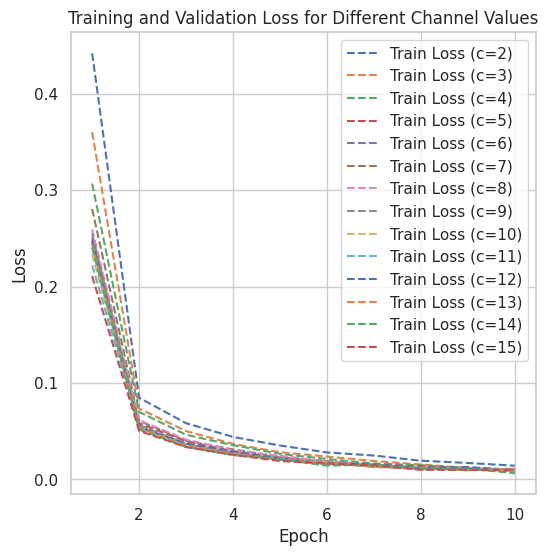

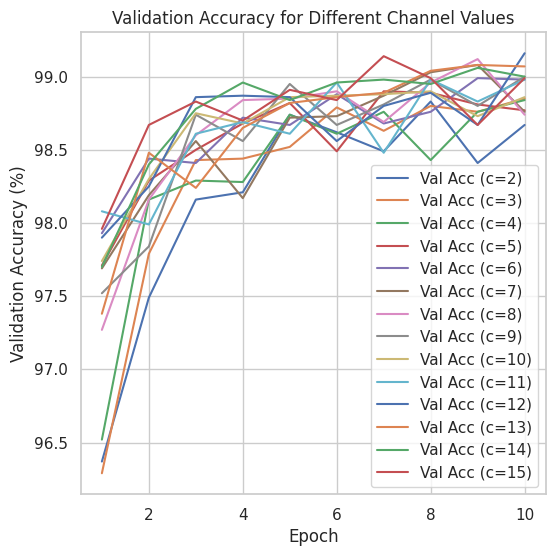

In [ ]:
sns.set(style="whitegrid")

# plot training loss
plt.figure(figsize=(6, 6))
for i, c in enumerate(channel_values):
    sns.lineplot(x=range(1, 11), y=all_train_losses[i], label=f'Train Loss (c={c})', linestyle='--')

plt.title('Training and Validation Loss for Different Channel Values')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot validation accuracy
plt.figure(figsize=(6, 6))
for i, c in enumerate(channel_values):
    sns.lineplot(x=range(1, 11), y=all_val_accuracies[i], label=f'Val Acc (c={c})')

plt.title('Validation Accuracy for Different Channel Values')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.show()

    Channels (c)  Mean Accuracy (%)  Std Dev (%)  Best Smoothed Accuracy (%)  \
0              2             98.199     0.711947                   98.636571   
1              3             98.330     0.740891                   98.857429   
2              4             98.339     0.647664                   98.846286   
3              5             98.586     0.347885                   98.910571   
4              6             98.646     0.302595                   99.035714   
5              7             98.580     0.415187                   99.041143   
6              8             98.613     0.509766                   98.946286   
7              9             98.587     0.477432                   98.949143   
8             10             98.657     0.349201                   98.898000   
9             11             98.621     0.336465                   99.011143   
10            12             98.682     0.346058                   99.057143   
11            13             98.651     

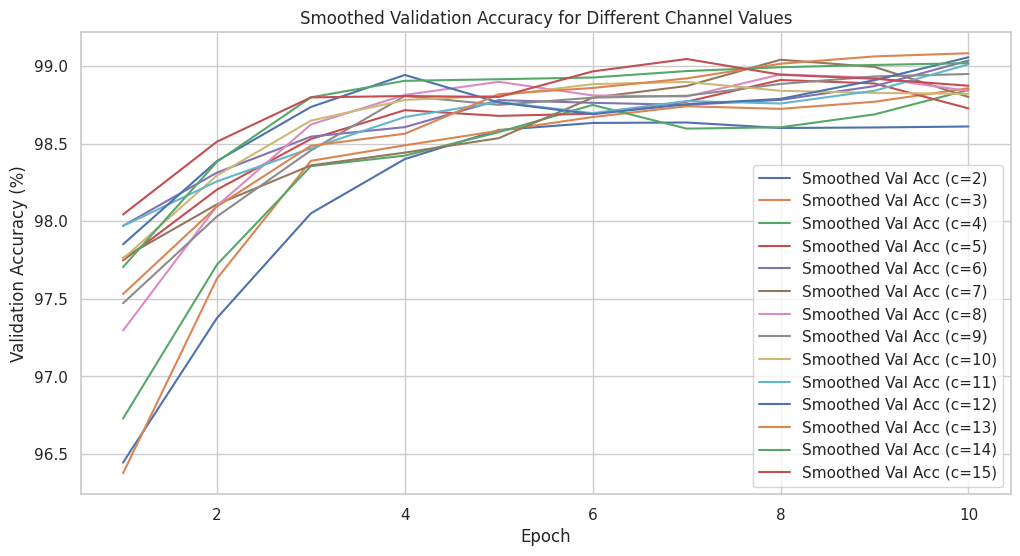

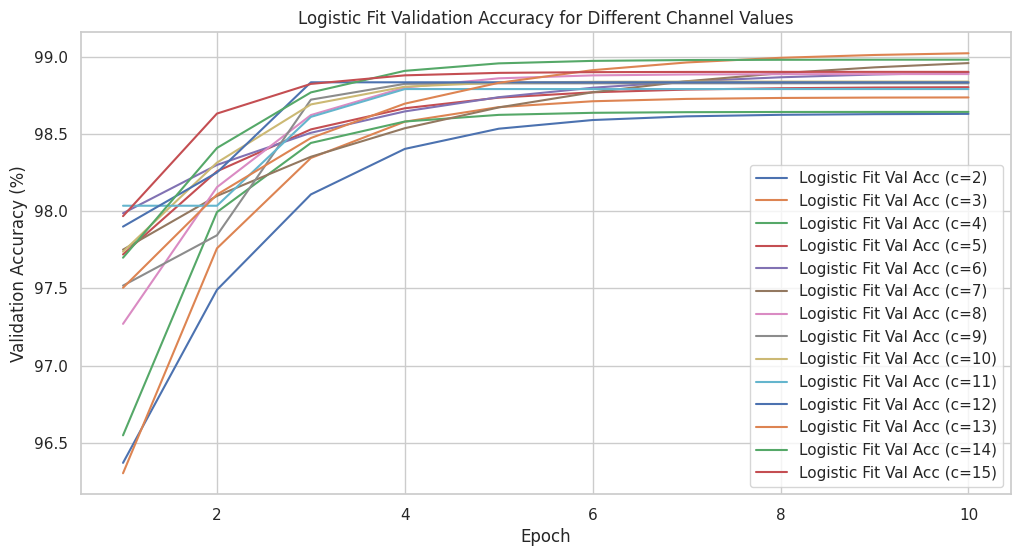

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd

# Smoothing the validation accuracy using Savitzky-Golay filter
from scipy.signal import savgol_filter

# Apply Savitzky-Golay filter to smooth the validation accuracy
# window_length must be odd and greater than the polynomial order
window_length = 5  # You can adjust this
polyorder = 2      # Polynomial order, can be adjusted based on your needs
smoothed_val_accuracies = [savgol_filter(val_acc, window_length=window_length, polyorder=polyorder) for val_acc in all_val_accuracies]

# Logistic function for curve fitting
def logistic(x, L ,x0, k, b):
    return L / (1 + np.exp(-k*(x-x0))) + b

# Fitting a logistic curve to the validation accuracy
fitted_curves = []
for val_acc in all_val_accuracies:
    x_data = np.arange(1, len(val_acc) + 1)
    # Initial guess for parameters L, x0, k, and b
    p0 = [max(val_acc), np.median(x_data), 1, min(val_acc)]
    popt, _ = curve_fit(logistic, x_data, val_acc, p0=p0, maxfev=10000)
    fitted_curves.append(logistic(x_data, *popt))

# Calculate mean accuracy and standard deviation for each c
mean_accuracies = [np.mean(val_acc) for val_acc in all_val_accuracies]
std_accuracies = [np.std(val_acc) for val_acc in all_val_accuracies]

# Create a summary table with the results
summary_data = {
    'Channels (c)': channel_values,
    'Mean Accuracy (%)': mean_accuracies,
    'Std Dev (%)': std_accuracies,
    'Best Smoothed Accuracy (%)': [max(smoothed) for smoothed in smoothed_val_accuracies],
    'Best Logistic Fit Accuracy (%)': [max(fit) for fit in fitted_curves],
}

summary_df = pd.DataFrame(summary_data)
summary_df['Best Channel (c) Based on Max Raw'] = summary_df['Mean Accuracy (%)'].idxmax() + 2  # Adding 2 since index starts from 0
summary_df['Best Channel (c) Based on Smoothed'] = summary_df['Best Smoothed Accuracy (%)'].idxmax() + 2
summary_df['Best Channel (c) Based on Logistic Fit'] = summary_df['Best Logistic Fit Accuracy (%)'].idxmax() + 2

# Output the summary table
print(summary_df)

# Plotting the results
sns.set(style="whitegrid")

# Plot smoothed validation accuracy
plt.figure(figsize=(12, 6))
for i, c in enumerate(channel_values):
    sns.lineplot(x=range(1, len(smoothed_val_accuracies[i]) + 1), y=smoothed_val_accuracies[i], label=f'Smoothed Val Acc (c={c})')

plt.title('Smoothed Validation Accuracy for Different Channel Values')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.show()

# Plot logistic fit validation accuracy
plt.figure(figsize=(12, 6))
for i, c in enumerate(channel_values):
    sns.lineplot(x=range(1, len(fitted_curves[i]) + 1), y=fitted_curves[i], label=f'Logistic Fit Val Acc (c={c})')

plt.title('Logistic Fit Validation Accuracy for Different Channel Values')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.show()


I ran the selection for C from 2-15 channels on the output of the first layer of the CNN. The results were all quite close and prone to variation. As such, I implemented a signal smoothing method (Savitzky-Golay) which was recommended for signal smoothing after a google search for its preservation of original shape and features, which I think makes it preferable to a simple moving average.

Based off of the smoothed data and the logistic fit, I liked the trends exhibited by c=13, so this is what I will use from now on for this data.

In [7]:
# updating model to reflect c choice
best_c = 13
model = CNN().to(device)
model.conv1 = nn.Conv2d(1, best_c, kernel_size=3, padding=1).to(device)
model.conv2 = nn.Conv2d(best_c, 64, kernel_size=3, padding=1).to(device)

RETRAIN

In [8]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

Training Epochs:  10%|█         | 1/10 [00:38<05:45, 38.41s/it]

Epoch [1/10], Train Loss: 0.2698, Validation Loss: 0.0911, Train Acc: 91.28%, Val Acc: 97.18%


Training Epochs:  20%|██        | 2/10 [01:01<03:55, 29.48s/it]

Epoch [2/10], Train Loss: 0.0576, Validation Loss: 0.0485, Train Acc: 98.16%, Val Acc: 98.41%


Training Epochs:  30%|███       | 3/10 [01:20<02:53, 24.77s/it]

Epoch [3/10], Train Loss: 0.0377, Validation Loss: 0.0410, Train Acc: 98.84%, Val Acc: 98.72%


Training Epochs:  40%|████      | 4/10 [01:36<02:07, 21.23s/it]

Epoch [4/10], Train Loss: 0.0269, Validation Loss: 0.0418, Train Acc: 99.11%, Val Acc: 98.61%


Training Epochs:  50%|█████     | 5/10 [01:52<01:36, 19.38s/it]

Epoch [5/10], Train Loss: 0.0236, Validation Loss: 0.0453, Train Acc: 99.23%, Val Acc: 98.49%


Training Epochs:  60%|██████    | 6/10 [02:08<01:12, 18.11s/it]

Epoch [6/10], Train Loss: 0.0177, Validation Loss: 0.0358, Train Acc: 99.42%, Val Acc: 98.92%


Training Epochs:  70%|███████   | 7/10 [02:23<00:51, 17.04s/it]

Epoch [7/10], Train Loss: 0.0137, Validation Loss: 0.0318, Train Acc: 99.53%, Val Acc: 99.04%


Training Epochs:  80%|████████  | 8/10 [02:38<00:33, 16.58s/it]

Epoch [8/10], Train Loss: 0.0114, Validation Loss: 0.0346, Train Acc: 99.62%, Val Acc: 99.10%


Training Epochs:  90%|█████████ | 9/10 [02:53<00:16, 16.08s/it]

Epoch [9/10], Train Loss: 0.0103, Validation Loss: 0.0511, Train Acc: 99.65%, Val Acc: 98.58%


Training Epochs: 100%|██████████| 10/10 [03:10<00:00, 19.05s/it]

Epoch [10/10], Train Loss: 0.0100, Validation Loss: 0.0337, Train Acc: 99.68%, Val Acc: 99.23%


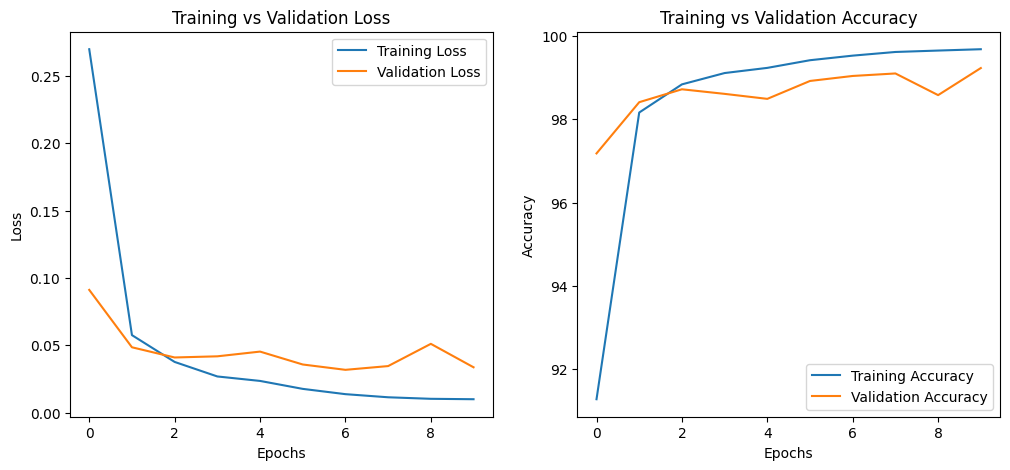

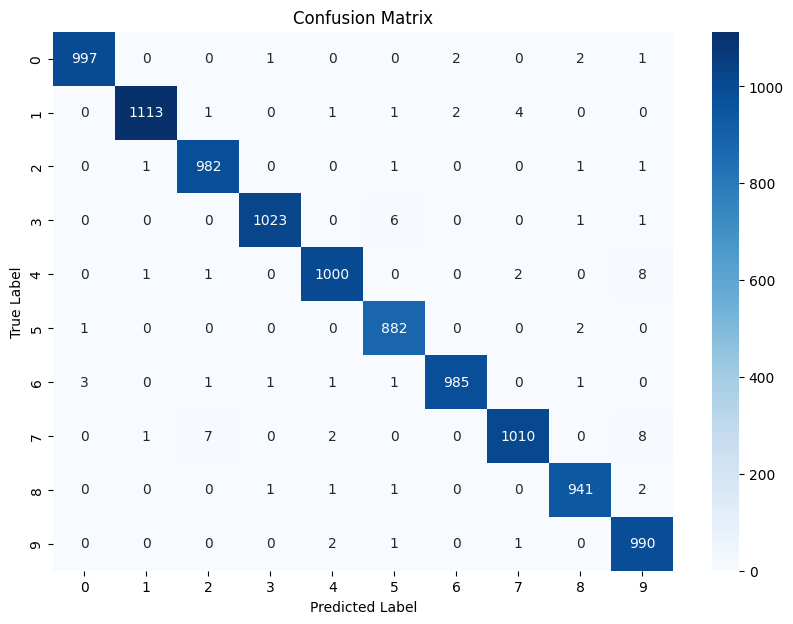

In [12]:
from sklearn.metrics import confusion_matrix

# loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.show()

# 3. confusion matrix
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

From the accuracy data we observe the same trend as before--the validation accuracy tends to plateau at 99% validation accuracy. It is possible that this would continue to improve with +99% but in the interest of time and the presence of diminishing returns we will end our training with a c=13 value at k=10 epochs

Afterwards, I wanted to visualize the predictions to see if there are any common mistakes made. The 2 most common mistaken number pairs are 2 & 7 and 4 & 9. This aligns with my intuition on what are the trickiest numbers, which increases my confidence that the CNN is working correctly (extracting features such as loops, lines, & circles) to identify digits.

## 5. Visualizing feature extraction

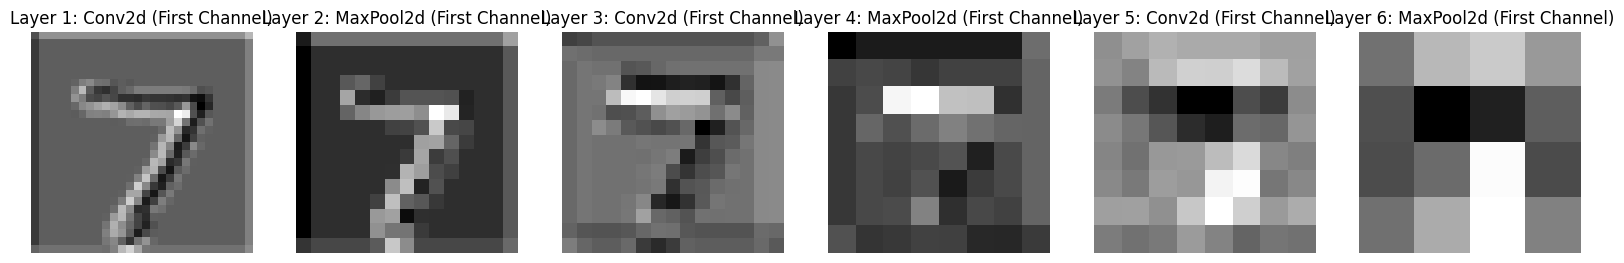

In [13]:
# get sample image from the test loader
examples = iter(test_loader)
example_data, _ = next(examples)
example_image = example_data[0]

# define the layers to visualize
layers = [model.conv1, model.pool, model.conv2, model.pool, model.conv3, model.pool_no_pad]

# visualize
plot_mapped_features(model, example_image, layers)

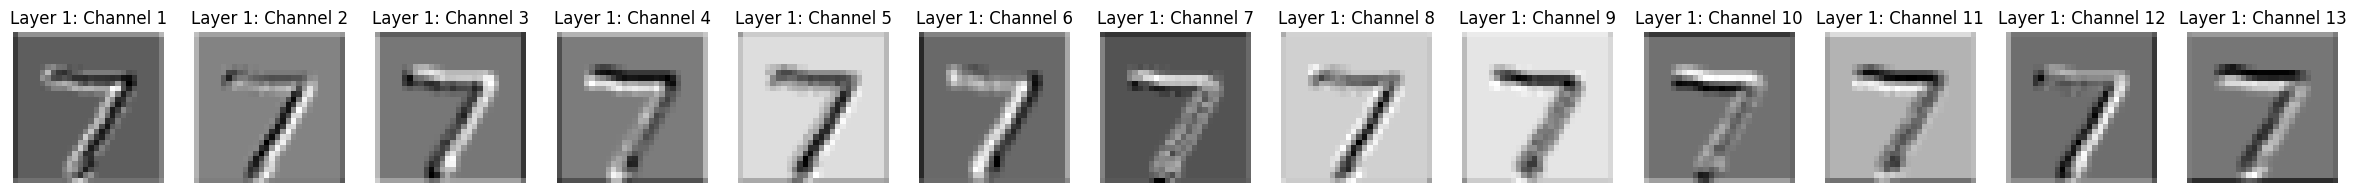

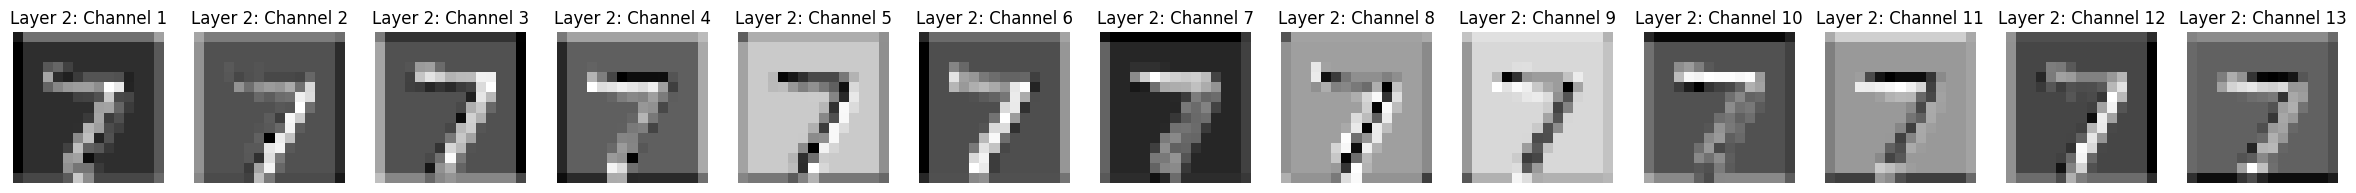

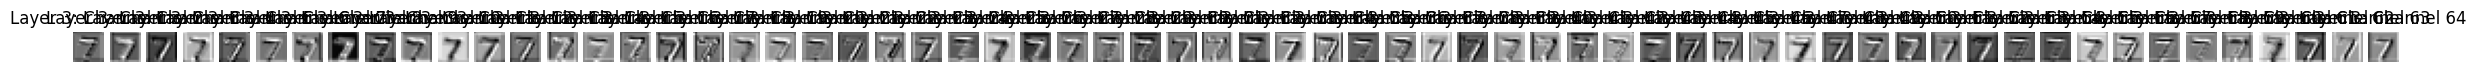

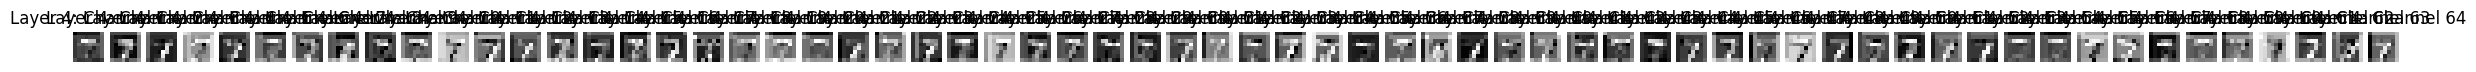

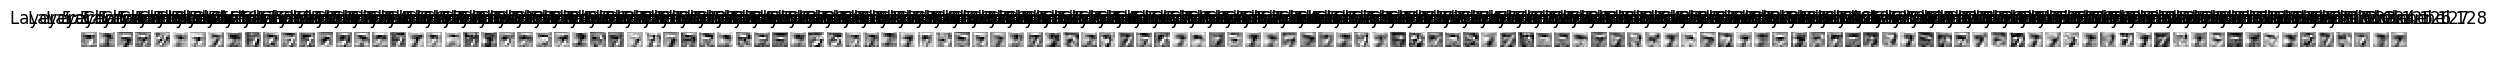

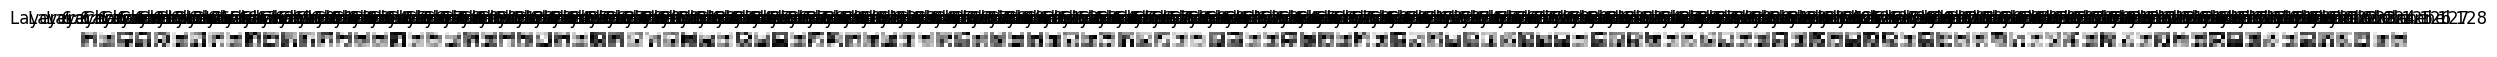

In [14]:
# visualize all channels
plot_mapped_features(model, example_image, layers, show_all_channels=True)

Observations:
Layer 1 (Conv2d First Channel):

The first image in the sequence shows the output after the first convolutional layer's first channel. This image is a slightly blurred version of the original input, emphasizing edges and features in the digit "7". The image still retains much of the original detail, showing that this layer is capturing basic features like edges.
Layer 2 (MaxPool2d First Channel):

After max pooling, the resolution of the image is reduced. The pooling layer emphasizes the most prominent features (like edges), which can be seen as a reduction in the image size but an increase in the clarity of essential features like the corners and strokes of the "7".

For the second layer, each channel emphasizes different aspects of the input image. Some channels might focus on vertical or horizontal edges, others on gradients or specific textures. This variability indicates that each channel learns to detect different features, which collectively contribute to a richer feature representation. But, while the exact emphasis varies from channel to channel, there is a common theme in the type of features each channel focuses on, such as edges or certain parts of the digit "7".

Beyond layer 2, it was difficult to pick out what the model was doing due to the increase of channels, yet it is clear that the 7 becomes more and more abstract -- reducing the image's resolution while highlighting the most crucial parts. Noteably, I saw Layer 4 clearly selecting entire chuncks of the "7" at a time!

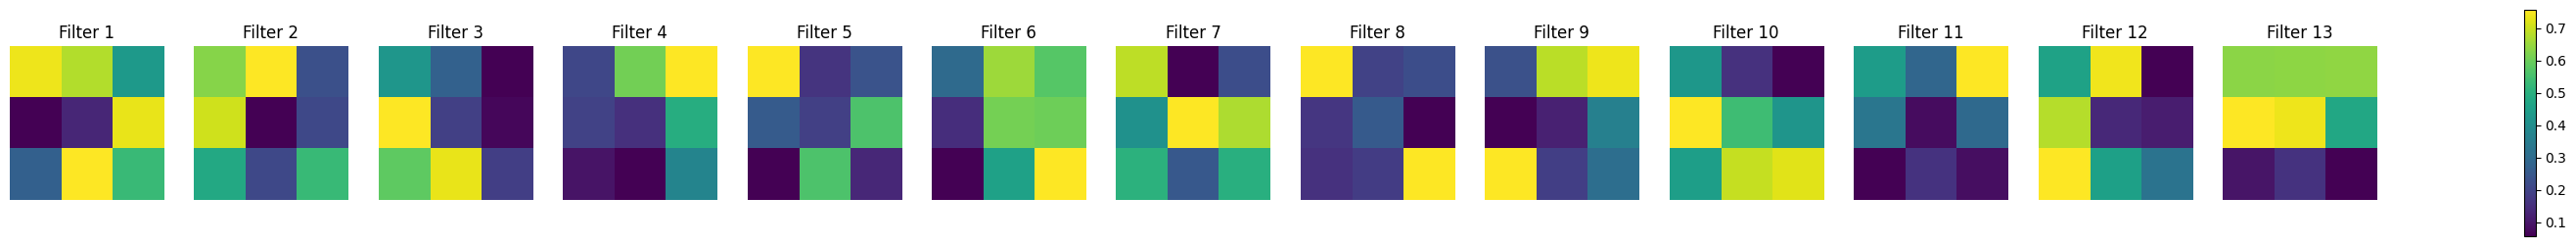

In [35]:
def plot_filters(layer, n_filters=6):
    """
    Visualize the filters of a given convolutional layer.

    Parameters:
    - layer: The convolutional layer whose filters are to be visualized
    - n_filters: The number of filters to visualize
    """
    # Clone the weights of the convolutional layer to avoid modifying the original weights
    filters = layer.weight.data.clone().cpu()
    # Normalize the filter values to the range [0, 1] for better visualization
    filters = filters - filters.min()
    filters = filters / filters.max()
    # Select the first n_filters to visualize
    filters = filters[:n_filters]

    fig, axes = plt.subplots(1, n_filters, figsize=(n_filters * 3, 3))

    # Iterate over the selected filters
    for i, filter in enumerate(filters):
        # Transpose the filter dimensions to (height, width, channels) for visualization
        axes[i].imshow(np.transpose(filter, (1, 2, 0)))

        axes[i].axis('off')
        axes[i].set_title(f'Filter {i+1}')

    plt.colorbar(axes[0].images[0], ax=axes.ravel().tolist())
    # Display the filters
    plt.show()

# Visualize the filters of the first convolutional layer with enhanced labels
plot_filters(model.conv1, n_filters=13)

## Task: Identify the filters that perform blurring, sharpening, or horizontal or vertical edge detection.

To determine if the filter is vlurring, sharpening, or performing edge detection I will look at the distrubution of pixels to which the filter assigns weights.

For blurring we would expect pixels in the 3x3 kernel to all contribute. For sharpening, we would expect the neighbouring pixels to be 'turned off' or have negative or low correlation with the center pixel. For edge detection, we would have a similar phenenema to sharpening but along horizontal or vertical lines.

(source I referenced: https://en.wikipedia.org/wiki/Kernel_(image_processing))



- Blurring Filter:

   - Filter 1
   - Filter 7
   - Filter 11

This filter provides a value to the center, but also to almost every other surrounding pixel. This creates a blur effect. Additionally, while 12 & 7 arent as uniform and doesnt value the center as much, I found them difficult to classify as edge detection or sharpening.


 - Sharpening Filters:

  - None?

Filters that show a strong contrast between the center and surrounding pixels, especially if the center pixel seems emphasized, are likely our sharpening filters. I could not seem to find filters that match my intuition.

- Horizontal Edge Detection Filters:

  - Filter 10
  - Filter 13

Horizontal edge detection filters typically have a pattern where one row of the filter has positive values, and the opposite row has negative values, with the middle row as zero or neutral. Filter 10 & 13 exhibit this stressing a strip of pixels below or above median respectively.

- Vertical Edge Detection Filters:
  - Filter 6
  - Filter 12

Similarly to the horizntal edge detection, I found two filters :one emphasizing the left of the median (12) and one emphasizing the right of the median (6) in a vertical strip of hgihgly weighted pixels

### Others (?!)

There were a few patters that I felt didnt match our criteria, and I hypothesized that even at layer one with 13 channels our CNN was picking out features such as angles and slanted lines (such as those important for the number 7 or corners in the number 4!)

- Corners or angles:
 - Filter 2 ( top right corner )
 - Filter 3 ( bottom left corner )

- Diagonals:
 - Filter 8 (top left to bottom right diagonal)
 - Filter 9 (bottom left to top right diagonal)

These exhibited similar behaviour to our edge filters, but notably emphaiszed the corners instead!




In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import time

# flatten images for logistic regression
train_loader = DataLoader(train_set, batch_size=60000, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10000, shuffle=False)

train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))

train_images = train_images.view(train_images.size(0), -1).numpy()
test_images = test_images.view(test_images.size(0), -1).numpy()

train_labels = train_labels.numpy()
test_labels = test_labels.numpy()

# normalize
train_images = train_images / 255.0
test_images = test_images / 255.0


In [28]:
# make model
logistic_regression = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs'))

# training time
start_time = time.time()
logistic_regression.fit(train_images, train_labels)
training_time = time.time() - start_time

# test accuracy
test_predictions = logistic_regression.predict(test_images)
test_accuracy = accuracy_score(test_labels, test_predictions)

print(f"Logistic Regression Training Time: {training_time:.4f} seconds")
print(f"Logistic Regression Test Accuracy: {test_accuracy * 100:.2f}%")


Logistic Regression Training Time: 218.0158 seconds
Logistic Regression Test Accuracy: 92.13%


In [ ]:
import torch.nn.functional as F
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np
import time

def get_hidden_state_batchwise(model, data_loader, layer_name):
    model.eval()
    logistic_regression = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3, random_state=42))

    for images, lbls in data_loader:
        images = images.to(device)

        x = model.conv1(images)
        x = F.relu(x)
        if layer_name == 'conv1':
            hidden_states = x.view(x.size(0), -1).detach().cpu().numpy()
            logistic_regression.partial_fit(hidden_states, lbls.numpy(), classes=np.unique(lbls.numpy()))
            continue

        x = model.pool(x)
        x = model.conv2(x)
        x = F.relu(x)
        if layer_name == 'conv2':
            hidden_states = x.view(x.size(0), -1).detach().cpu().numpy()
            logistic_regression.partial_fit(hidden_states, lbls.numpy(), classes=np.unique(lbls.numpy()))
            continue

        x = model.pool(x)
        x = model.conv3(x)
        x = F.relu(x)
        if layer_name == 'conv3':
            hidden_states = x.view(x.size(0), -1).detach().cpu().numpy()
            logistic_regression.partial_fit(hidden_states, lbls.numpy(), classes=np.unique(lbls.numpy()))
            continue

        x = model.pool_no_pad(x)
        x = x.view(x.size(0), -1)
        x = model.fc1(x)
        x = F.relu(x)
        if layer_name == 'fc1':
            hidden_states = x.detach().cpu().numpy()
            logistic_regression.partial_fit(hidden_states, lbls.numpy(), classes=np.unique(lbls.numpy()))
            continue

    return logistic_regression

layer_names = ['conv1', 'conv2', 'conv3', 'fc1']

logistic_models = {}

for layer in layer_names:
    print(f"Training logistic regression on features from {layer}")
    logistic_models[layer] = get_hidden_state_batchwise(model, train_loader, layer)

for layer in layer_names:
    test_hidden_states = []
    test_labels = []
    for images, lbls in test_loader:
        images = images.to(device)

        x = model.conv1(images)
        x = F.relu(x)
        if layer == 'conv1':
            hidden_states = x.view(x.size(0), -1).detach().cpu().numpy()
            test_predictions = logistic_models[layer].predict(hidden_states)
            test_labels.append(lbls.numpy())
            continue

        x = model.pool(x)
        x = model.conv2(x)
        x = F.relu(x)
        if layer == 'conv2':
            hidden_states = x.view(x.size(0), -1).detach().cpu().numpy()
            test_predictions = logistic_models[layer].predict(hidden_states)
            test_labels.append(lbls.numpy())
            continue

        x = model.pool(x)
        x = model.conv3(x)
        x = F.relu(x)
        if layer == 'conv3':
            hidden_states = x.view(x.size(0), -1).detach().cpu().numpy()
            test_predictions = logistic_models[layer].predict(hidden_states)
            test_labels.append(lbls.numpy())
            continue

        x = model.pool_no_pad(x)
        x = x.view(x.size(0), -1)
        x = model.fc1(x)
        x = F.relu(x)
        if layer == 'fc1':
            hidden_states = x.detach().cpu().numpy()
            test_predictions = logistic_models[layer].predict(hidden_states)
            test_labels.append(lbls.numpy())
            continue

    test_labels = np.hstack(test_labels)
    test_accuracy = accuracy_score(test_labels, test_predictions)

    print(f"Logistic regression test accuracy using {layer} features: {test_accuracy * 100:.2f}%")


training logistic regression on features from conv1


Unfortunately crashes due to RAM usage

In [ ]:
for layer in layer_names:
    logistic_regression.fit(hidden_states[layer], labels[layer])

    # test on hidden states from the test set
    test_hidden_states, test_labels = get_hidden_state(model, test_loader, layer)

    test_predictions = logistic_regression.predict(test_hidden_states)
    test_accuracy = accuracy_score(test_labels, test_predictions)

    print(f"Logistic Regression Test Accuracy using {layer} features: {test_accuracy * 100:.2f}%")
